In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import multiprocessing

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import pandas as pd
import numpy as np
import numpyro

from hbmep.config import Config
from hbmep.model import Baseline
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()


In [2]:
root_path = Path(os.getcwd()).parent.parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/rcml/fcr.toml")

config = Config(toml_path=toml_path)

model = Baseline(config=config)

df = pd.read_csv(model.csv_path)

ind = df.pulse_amplitude.isin([0])
df = df[~ind].reset_index(drop=True).copy()

# subset = ['-C5L', '-C6L', '-C7L', '-C8L']
subset = ['C5M-C5L', 'C6M-C6L', 'C7M-C7L', 'C8M-C8L']

ind = df.compound_position.isin(subset)
df = df[ind].reset_index(drop=True).copy()

""" Process """
df, encoder_dict = model.load(df=df)


2023-08-15 16:19:06,233 - hbmep.config - INFO - Verifying configuration ...
2023-08-15 16:19:06,233 - hbmep.config - INFO - Success!
2023-08-15 16:19:06,253 - hbmep.model.baseline - INFO - Initialized model with baseline link
2023-08-15 16:19:06,276 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/J_RCML_000/fcr
2023-08-15 16:19:06,277 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/J_RCML_000/fcr
2023-08-15 16:19:06,278 - hbmep.dataset.core - INFO - Processing data ...
2023-08-15 16:19:06,279 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [3]:
df.shape

(1403, 44)

In [4]:
subjects = df[model.subject].unique()
conditions = df[model.features[0]].unique()
combinations = model._make_combinations(df=df, columns=model.combination_columns)

subs_at_pos = {}

for pos in conditions:
    subs_at_pos[pos] = [sub for sub in subjects if (sub, pos) in combinations]


In [5]:
muscles = ["deltoid", "biceps", "triceps", "ecr", "fcr", "adm"]

mat = []

for muscle in muscles:
    # src = f"/home/vishu/repos/hbmep-paper/reports/J_RCML_000/{muscle}"
    src = f"/home/vishu/repos/hbmep-paper/reports/J_RCML_000_non_ground/{muscle}"

    mcmc = az.from_netcdf(os.path.join(src, "mcmc.nc"))["posterior"]
    a = mcmc[site.a].to_numpy()[..., 0]
    a = a.reshape(-1, *a.shape[2:])

    a_map = a.mean(axis=0)

    mat.append(a_map.tolist())

mat = np.array(mat)

# mat = mat - mat.mean(axis=0)


In [6]:
# import scipy.io as sio

# sio.savemat('/home/vishu/repos/hbmep-paper/notebooks/J_RCML_000.mat', {'mat': mat})


In [8]:
mat.shape

(6, 4, 8)

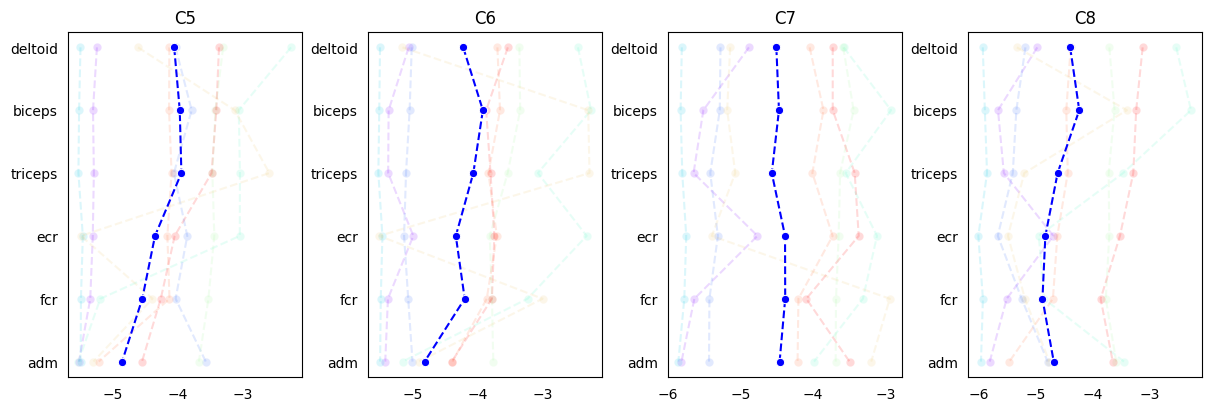

In [57]:
temp_mat = (1 / (mat + 1))
# mat1 = (temp_mat - temp_mat.mean(axis=(0, 1))[None, None, :]) / temp_mat.std(axis=(0, 1))[None, None, :]

use_mat = np.log(temp_mat)
mat_mean = use_mat.mean(axis=-1)

n_muscles = len(muscles)
n_positions = 4

fig, axes = plt.subplots(ncols=n_positions, nrows=1, figsize=(n_positions * 3, 4), constrained_layout=True)

for pos in range(4):
    ax = axes[pos]
    color = iter(plt.cm.rainbow(np.linspace(0, 1, 8)))

    for i in range(8):
        c = next(color)
        sns.lineplot(x=use_mat[:, pos, i], y=muscles, marker="o", linestyle="dashed", alpha=.15, color=c, orient="y", ax=ax)

    sns.lineplot(x=mat_mean[:, pos], y=muscles, marker="o", linestyle="dashed", orient="y", color="b", ax=ax)

    ax.tick_params(top=False,
                bottom=False,
                left=False,
                right=False,
                labelleft=True,
                labelbottom=True)

    pos_inv = encoder_dict[model.features[0]].inverse_transform(np.array([pos]))[0]
    ax.set_title(f"{pos_inv[:2]}")

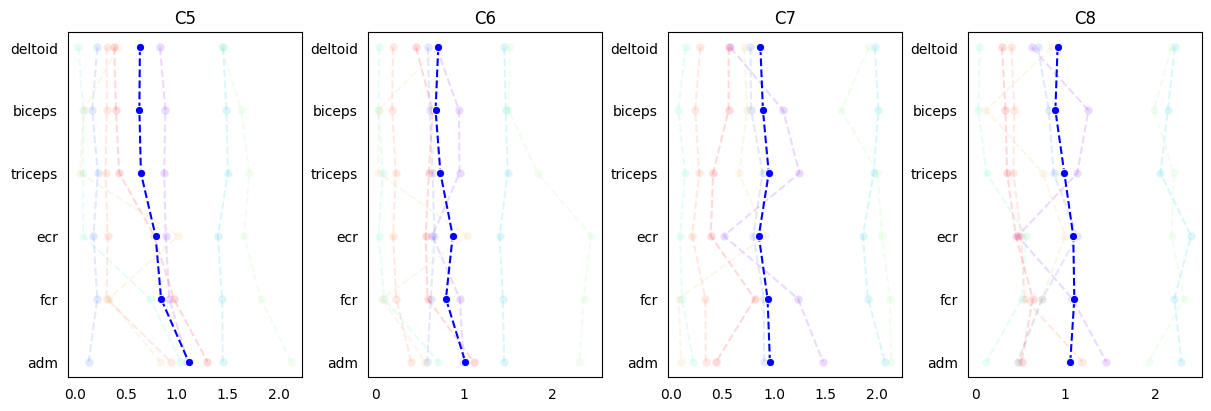

In [30]:
temp_mat = mat

mat2 = temp_mat / (
    temp_mat.max(axis=(0, 1))[None, None, :] - temp_mat.min(axis=(0, 1))[None, None, :]
)

use_mat = mat2
mat_mean = use_mat.mean(axis=-1)

n_muscles = len(muscles)
n_positions = 4

fig, axes = plt.subplots(ncols=n_positions, nrows=1, figsize=(n_positions * 3, 4), constrained_layout=True)

for pos in range(4):
    ax = axes[pos]
    color = iter(plt.cm.rainbow(np.linspace(0, 1, 8)))

    for i in range(8):
        c = next(color)
        sns.lineplot(x=use_mat[:, pos, i], y=muscles, marker="o", linestyle="dashed", alpha=.15, color=c, orient="y", ax=ax)

    sns.lineplot(x=mat_mean[:, pos], y=muscles, marker="o", linestyle="dashed", orient="y", color="b", ax=ax)

    ax.tick_params(top=False,
                bottom=False,
                left=False,
                right=False,
                labelleft=True,
                labelbottom=True)

    pos_inv = encoder_dict[model.features[0]].inverse_transform(np.array([pos]))[0]
    ax.set_title(f"{pos_inv[:2]}")

In [25]:
mat.shape

(6, 4, 8)

In [ ]:
mat2 = mat / (
    mat.max(axis=(0, 1))[None, None, :] - mat.min(axis=(0, 1))[None, None, :]
)

use_mat = mat2
mat_mean = use_mat.mean(axis=-1)

n_muscles = len(muscles)
n_positions = 4

fig, axes = plt.subplots(ncols=n_positions, nrows=1, figsize=(n_positions * 3, 4), constrained_layout=True)

for pos in range(4):
    ax = axes[pos]
    color = iter(plt.cm.rainbow(np.linspace(0, 1, 8)))

    for i in range(8):
        c = next(color)
        sns.lineplot(x=use_mat[:, pos, i], y=muscles, marker="o", linestyle="dashed", alpha=.15, color=c, orient="y", ax=ax)

    sns.lineplot(x=mat_mean[:, pos], y=muscles, marker="o", linestyle="dashed", orient="y", color="b", ax=ax)

    ax.tick_params(top=False,
                bottom=False,
                left=False,
                right=False,
                labelleft=True,
                labelbottom=True)

    pos_inv = encoder_dict[model.features[0]].inverse_transform(np.array([pos]))[0]
    ax.set_title(f"{pos_inv[:2]}")

In [ ]:
mat1 = mat - 

In [7]:

mat_mean = mat.mean(axis=-1)
mat_mean.shape

(6, 4)

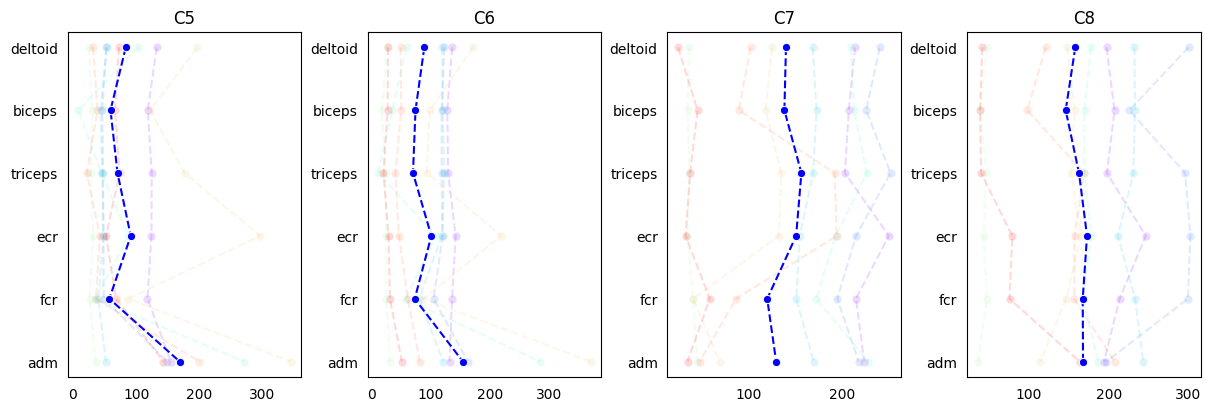

In [8]:
n_muscles = len(muscles)
n_positions = 4

fig, axes = plt.subplots(ncols=n_positions, nrows=1, figsize=(n_positions * 3, 4), constrained_layout=True)

for pos in range(4):
    ax = axes[pos]
    color = iter(plt.cm.rainbow(np.linspace(0, 1, 8)))

    for i in range(8):
        c = next(color)
        sns.lineplot(x=mat[:, pos, i], y=muscles, marker="o", linestyle="dashed", alpha=.15, color=c, orient="y", ax=ax)

    sns.lineplot(x=mat_mean[:, pos], y=muscles, marker="o", linestyle="dashed", orient="y", color="b", ax=ax)

    ax.tick_params(top=False,
                bottom=False,
                left=False,
                right=False,
                labelleft=True,
                labelbottom=True)

    pos_inv = encoder_dict[model.features[0]].inverse_transform(np.array([pos]))[0]
    ax.set_title(f"{pos_inv[1:-1]}")


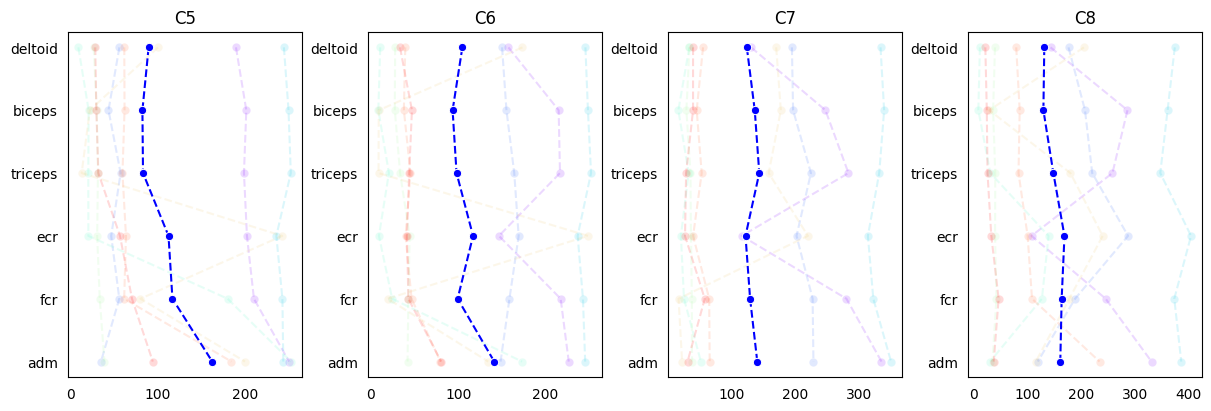

In [9]:
n_muscles = len(muscles)
n_positions = 4

fig, axes = plt.subplots(ncols=n_positions, nrows=1, figsize=(n_positions * 3, 4), constrained_layout=True)

for pos in range(4):
    ax = axes[pos]
    color = iter(plt.cm.rainbow(np.linspace(0, 1, 8)))

    for i in range(8):
        c = next(color)
        sns.lineplot(x=mat[:, pos, i], y=muscles, marker="o", linestyle="dashed", alpha=.15, color=c, orient="y", ax=ax)

    sns.lineplot(x=mat_mean[:, pos], y=muscles, marker="o", linestyle="dashed", orient="y", color="b", ax=ax)

    ax.tick_params(top=False,
                bottom=False,
                left=False,
                right=False,
                labelleft=True,
                labelbottom=True)

    pos_inv = encoder_dict[model.features[0]].inverse_transform(np.array([pos]))[0]
    ax.set_title(f"{pos_inv[:2]}")


In [11]:
mat.shape

(6, 4, 8)